# Thai Word Segmentation using Deep Learning
Teerapong Taengmuang (office.taengmuang@gmail.com)

## Load Dataset
Download dataset from https://www.nectec.or.th/corpus/index.php?league=pm

In [1]:
from glob import glob
import numpy as np

List file path

In [2]:
files = glob('../BEST I Corpus/*/*')
print('Number of files: ', len(files))

Number of files:  506


## Load Dictionary
Loading char indices dictionary in to CHAR_INDICES variable

In [3]:
import json

def read_json(fname, key_int=False):
    with open(fname, 'r') as file:
        data = file.read()
        json_data = json.loads(data)
        
        if not key_int:
            return json_data
        
        json_data = {int(key): value for key, value in json_data.items()}
        return json_data

In [4]:
CHAR_INDICES = read_json('../models/CHAR_INDICES.json', key_int=False)

## Preprocessing
1. Read text from each file
2. Remove inappropriate word/char
3. Create dataset (sequence data for LSTM)
4. Data ecoding (one-hot encoding)

In [5]:
def replace(text, wordlist):
    for new_word, list_ in wordlist.items():
        for old_word in list_:
            text = text.replace(old_word.lower(), new_word)
    return text

    
def preprocessing(text, wordlist):
    text = text.lower()  # to lower-case
    text = replace(text, wordlist)
    return text


def create_dataset(text, look_back=20):
    X, y = [], []
    text = '|' + text
    data = [CHAR_INDICES['<pad>']] * look_back
    for i in range(1, len(text)):
        current_char = text[i]
        before_char = text[i-1]

        if current_char == '|':
            continue

        data = data[1:] + [CHAR_INDICES[current_char]]  # X data
        target = 1 if before_char == '|' else 0  # y data

        X.append(data)
        y.append(target)
    y[-1] = 1  # end text is '|'
    return X, y


def encode_data(X, y):
    sequence_len = len(X[0])
    encode_X = np.zeros((len(X), sequence_len, len(CHAR_INDICES)), dtype=np.bool)
    encode_y = np.zeros((len(y), 2), dtype=np.bool)
    for i, (data, target) in enumerate(zip(X, y)):
        for t, char in enumerate(data):
            encode_X[i, t, char] = 1
        encode_y[i, target] = 1
        
    return encode_X, encode_y


def read_text(file):
    return open(file, encoding='utf-8').read()

## Train-Test-Validate
Random file name for train, test and validate

In [6]:
import random

def train_test_split(files, test_size=0.3):
    random.shuffle(files)
    test_size = int(len(files) * test_size)
    train, test = files[:-test_size], files[-test_size:]
    return train, test

In [7]:
file_train, file_test = train_test_split(files, test_size=0.03)
file_train, file_validate = train_test_split(file_train, test_size=0.03)

In [8]:
print('Number of file for traing:', len(file_train))
print('Number of file for validate:',len(file_validate))
print('Number of file for test:', len(file_test))

Number of file for traing: 477
Number of file for validate: 14
Number of file for test: 15


## Create Model

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Bidirectional
from keras.utils.vis_utils import plot_model
from IPython.display import Image
import copy

Using TensorFlow backend.


Count number of each dataset (train, test ,validate)

In [44]:
wordlist = {
    '': ['<AB>', '</AB>', '<NE>', '</NE>', '\n'],
}

wordlist2 = copy.deepcopy(wordlist)
wordlist2[''].append('|')

nb_data_train = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_train)
nb_data_validate = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_validate)
nb_data_test = sum(len(preprocessing(read_text(file), wordlist2)) for file in file_test)

print('Number of data on train set: ', nb_data_train)
print('Number of data on validate set: ', nb_data_validate)
print('Number of data on test set: ', nb_data_test)
print('Number of all data: ', sum([nb_data_train, nb_data_validate, nb_data_test]))

Number of data on train set:  19531501
Number of data on validate set:  654259
Number of data on test set:  583377
Number of all data:  20769137


Config var

In [11]:
LOOK_BACK = 20
batch_size = 1024
steps_per_epoch = int(nb_data_train / batch_size)
validation_steps = int(nb_data_train / (batch_size * 10))

In [12]:
def define_model(input_shape):
    model = Sequential()
    model.add(
        Bidirectional(LSTM(input_shape[1]//2, input_shape=input_shape,
                           return_sequences=False),
                      merge_mode='sum',
                      weights=None,
                      input_shape=input_shape))
    model.add(Dense(input_shape[1]//4, activation='linear'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])  # compile
    
    print('Total params: ', model.count_params())
    return model

Build model and plot model

Instructions for updating:
Colocations handled automatically by placer.
Total params:  199307


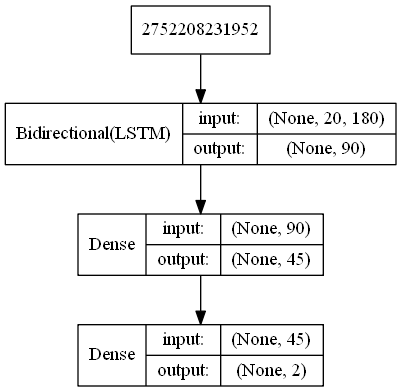

In [13]:
input_shape = (LOOK_BACK, len(CHAR_INDICES))
model = define_model(input_shape)  # define model

# plot model
image_name = '../images/model.png'
plot_model(model, image_name, show_shapes=True, show_layer_names=False)
display(Image(filename=image_name))

Create *GENERATOR* for training **LARGE dataset**

In [14]:
import math

def generator(files, wordlist, batch_size=1024, look_back=20, mode='Training', display_=False):
    while True:
        copy_files = files.copy()
        random.shuffle(copy_files)

        for file in copy_files:
            if display_ is True:
                print(f'\n{mode} file: ' + file)

            text = read_text(file)
            text = preprocessing(text, wordlist)
            X_data, y_data = create_dataset(text, look_back)
            X_data, y_data = encode_data(X_data, y_data)

            samples_per_epoch  = len(X_data)
            number_of_batches = int(math.ceil(samples_per_epoch / batch_size))

            for counter in range(number_of_batches):
                X_batch = np.array(X_data[batch_size*counter:batch_size*(counter+1)])
                y_batch = np.array(y_data[batch_size*counter:batch_size*(counter+1)])
                yield X_batch, y_batch

In [15]:
# Generators
training_generator = generator(file_train, 
                               wordlist, 
                               batch_size, 
                               look_back=LOOK_BACK, 
                               mode='Training')

validation_generator = generator(file_validate, 
                                 wordlist, 
                                 batch_size, 
                                 look_back=LOOK_BACK, 
                                 mode='Validation')

print('steps per epoch', steps_per_epoch)
print('validation steps', validation_steps)

steps per epoch 19073
validation steps 1907


### Callbacks  
Callback config  
- checkpoint
- step decay

In [19]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from matplotlib import pyplot as plt

In [17]:
# checkpoint
filepath="../models/weights-improvement-{epoch:03d}-{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

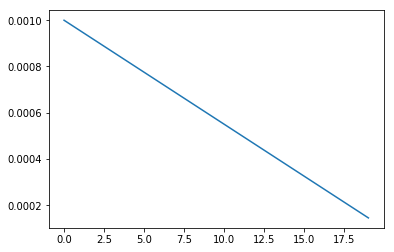

In [25]:
# step decay

def step_decay(epoch):
    initial_lrate = 0.001
    min_lrat = 0.0001
    drop_per_epoch = (initial_lrate - min_lrat) / NB_EPOCH
    lrate = initial_lrate - (drop_per_epoch * epoch)
    return lrate

NB_EPOCH = 20
lrate = LearningRateScheduler(step_decay)

plt.plot([step_decay(i) for i in range(NB_EPOCH)]);
plt.savefig('../images/step-decay.png')

In [21]:
callbacks_list = [checkpoint, lrate]

In [22]:
# training
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=NB_EPOCH,
                    verbose=1,
                    callbacks=callbacks_list)

# # save model
# model.save('thai-word-segmentation-model.hdf5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
19073/19073 [==============================] - 1429s 75ms/step - loss: 0.0930 - acc: 0.9647 - val_loss: 0.0879 - val_acc: 0.9687

Epoch 00001: val_acc improved from -inf to 0.96866, saving model to ../models/weights-improvement-001-0.969.hdf5
Epoch 2/20
19073/19073 [==============================] - 1423s 75ms/step - loss: 0.0596 - acc: 0.9792 - val_loss: 0.0668 - val_acc: 0.9766

Epoch 00002: val_acc improved from 0.96866 to 0.97656, saving model to ../models/weights-improvement-002-0.977.hdf5
Epoch 3/20
19073/19073 [==============================] - 1420s 74ms/step - loss: 0.0523 - acc: 0.9818 - val_loss: 0.0650 - val_acc: 0.9768

Epoch 00003: val_acc improved from 0.97656 to 0.97678, saving model to ../models/weights-improvement-003-0.977.hdf5
Epoch 4/20
19073/19073 [==============================] - 1420s 74ms/step - loss: 0.0488 - acc: 0.9832 - val_loss: 0.0596 - val_acc: 0.9795

Epoch 00004: val_acc improved from 0.97678 

Model history plot
- loss
- acc

history key:  ['val_loss', 'val_acc', 'loss', 'acc', 'lr']


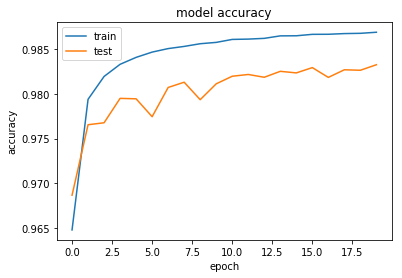

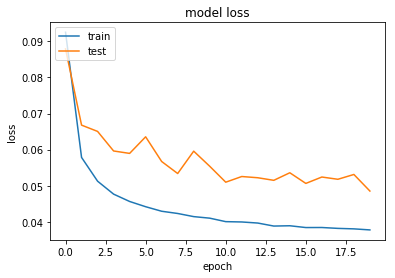

In [23]:
plot_pathsave = '../images/history-{}.png'

# keys of history
print('history key: ', list(history.history.keys()))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(plot_pathsave.format('acc'))  # save to image
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(plot_pathsave.format('loss'))  # save to image
plt.show()

## Evaluate
Evaluate each file on test and calculate mean score.  
Loading best model (best **acc score** on validate set).

Metrics
- precision
- recall
- fscore

Using sklearn
- precision_recall_fscore_support: average='binary'
- accuracy_score

In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from keras.models import load_model

In [28]:
best_model_checkpoint = sorted(glob('../models/*'))[-1]
print(best_model_checkpoint)

best_model = load_model(best_model_checkpoint)  # load Model

../models\weights-improvement-020-0.983.hdf5


In [29]:
def pred_preprocessing(text, sequence_len=20):
    # create dataset
    X = []
    data = [CHAR_INDICES['<pad>']] * sequence_len
    for char in text:
        char = char if char in CHAR_INDICES else '<unk>'  # check char in dictionary
        data = data[1:] + [CHAR_INDICES[char]]  # X data
        X.append(data)
        
    # data encoding
    encode_X = np.zeros((len(X), sequence_len, len(CHAR_INDICES)), dtype=np.bool)
    for i, data in enumerate(X):
        for t, char in enumerate(data):
            encode_X[i, t, char] = 1
    return encode_X


def predict(model, text_encode):
    preds = model.predict(text_encode)
    class_ = [np.argmax(pred) for pred in preds]
    return class_

In [31]:
avg = {
    'precision': [],
    'recall': [],
    'fscore': [],
    'acc': []
}

for i, fpath in enumerate(file_test):
    print(f'{i+1}/{len(file_test)}: ', fpath)
    
    _, y_true = create_dataset(preprocessing(read_text(fpath), wordlist), look_back=LOOK_BACK)
    y_pred = predict(best_model, pred_preprocessing(preprocessing(read_text(fpath), wordlist2)))
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    acc = accuracy_score(y_true, y_pred)
    
    avg['precision'].append(precision)
    avg['recall'].append(recall)
    avg['fscore'].append(fscore)
    avg['acc'].append(acc)
    
    print('precision: ', round(precision, 3))
    print('recall: ', round(recall, 3))
    print('fscore: ', round(fscore, 3))
    print('accuracy: ' , round(acc, 3))
    print('Number of data: ', len(y_pred))
    print('-' * 50)

1/15:  ../BEST I Corpus\article\article_00013.txt
precision:  0.959
recall:  0.978
fscore:  0.968
accuracy:  0.983
Number of data:  21598
--------------------------------------------------
2/15:  ../BEST I Corpus\article\article_00055.txt
precision:  0.96
recall:  0.983
fscore:  0.971
accuracy:  0.984
Number of data:  39442
--------------------------------------------------
3/15:  ../BEST I Corpus\article\article_00179.txt
precision:  0.984
recall:  0.989
fscore:  0.986
accuracy:  0.993
Number of data:  21500
--------------------------------------------------
4/15:  ../BEST I Corpus\article\article_00184.txt
precision:  0.98
recall:  0.989
fscore:  0.984
accuracy:  0.992
Number of data:  31541
--------------------------------------------------
5/15:  ../BEST I Corpus\article\article_00005.txt
precision:  0.961
recall:  0.984
fscore:  0.973
accuracy:  0.984
Number of data:  27474
--------------------------------------------------
6/15:  ../BEST I Corpus\novel\novel_00043.txt
precision: 

In [32]:
# mean value

precision = round(np.mean(avg['precision']), 3)
recall = round(np.mean(avg['recall']), 3)
fscore = round(np.mean(avg['fscore']), 3)
acc = round(np.mean(avg['fscore']), 3)

print('mean precision: ', round(precision, 3))
print('mean recall: ', round(recall, 3))
print('mean fscore: ', round(fscore, 3))
print('mean accuracy: ', round(acc, 3))

mean precision:  0.967
mean recall:  0.981
mean fscore:  0.974
mean accuracy:  0.974


## Make Thai Word Tokenizer

In [33]:
def word_tokenize(model, text):
    input_text_encode = pred_preprocessing(text)
    class_ = predict(model, input_text_encode) + [1]
    cut_indexs = [i for i, value in enumerate(class_) if value == 1]
    words = [text[cut_indexs[i]:cut_indexs[i+1]] for i in range(len(cut_indexs)-1)]
    return words

Sample text input from test set

In [34]:
text = preprocessing(read_text(file_test[0]), wordlist2)
display(text)

'บทวิจารณ์ - จากมุมมองทางจริยธรรมส.ศิวรักษ์ : ศูนย์บันเทิงครบวงจรของรัฐบาลทักษิณสุลักษณ์ ศิวรักษ์ - นักวิชาการพุทธศาสนาบทความนี้ยาวประมาณ 10 หน้ากระดาษ a4เผยแพร่ครั้งแรกบทเว็ปมหาวิทยาลัยเที่ยงคืน วันที่ 31 มกราคม 2547ผลกระทบนโยบายศูนย์บันเทิงครบวงจรของรัฐบาลทักษิณต่อการพัฒนาแก้ไขปัญหาความยากจน : จากมุมมองทางจริยธรรม-๑-ประการแรก ขอยืนยันว่ามุมมองหรือทัศนะทางจริยธรรมนั้น ไม่ได้อยู่ในสายตาของนายกรัฐมนตรีทักษิณ ชินวัตรเอาเลย แม้เขาจะอ้างว่าเป็นพุทธศาสนิก นั่นเป็นคำลวง ที่เขาหลอกตนเองและมหาชน จนเขาเองก็เชื่อตามคำลวงของเขา นักการเมือง นักการค้าและนักโฆษณาชวนเชื่อทั้งหลาย ชอบใช้ถ้อยคำที่เป็นมุสาวาทอยู่เนืองนิตย์จนเชื่อในถ้อยคำนั้นๆเอาเลย ดังคนที่คุ้นอยู่กับความรุนแรง ย่อมยากที่จะเข้าใจได้ในหนทางของสันติภาวะ หรือคนที่คุ้นอยู่กับความโลภ ย่อมยากที่จะเข้าใจได้ในเรื่องของสันโดษพระภิกษุรูปหนึ่งเขียนบทความลงมติชน รายวัน ฉบับวันที่ ๔ ธันวาคม ๒๕๔๖ อย่างน่ารับฟังมาก หากไม่มีปฏิกิริยาใดๆจากคนในรัฐบาลปัจจุบันเอาเลย จึงขอนำเอามาอ่านให้ฟังกันดังต่อไปนี้พ.ต.ท.ทักษิณ ชินวัตร นั้นประสบความสำเร็จอย่างสูงตามกรอ

In [36]:
words = word_tokenize(best_model, text)
print('|'.join(words))

บท|วิจารณ์| |-| |จาก|มุมมอง|ทาง|จริยธรรม|ส.ศิวรักษ์| |:| |ศูนย์บันเทิง|ครบ|วงจร|ของ|รัฐบาล|ทักษิณ|สุลักษณ์| |ศิวรักษ์| |-| |นัก|วิชาการ|พุทธศาสนา|บทความ|นี้|ยาว|ประมาณ| |10| |หน้า|กระดาษ| |a|4|เผยแพร่|ครั้ง|แรก|บท|เว็ปมหาวิทยาลัย|เที่ยงคืน| |วัน|ที่| |31| |มกราคม| |2547|ผล|กระทบ|นโยบาย|ศูนย์|บันเทิง|ครบ|วงจร|ของ|รัฐบาล|ทักษิณ|ต่อ|การ|พัฒนา|แก้ไข|ปัญหา|ความ|ยากจน| |:| |จาก|มุมมอง|ทาง|จริยธรรม|-|๑|-|ประการ|แรก| |ขอ|ยืนยัน|ว่า|มุมมอง|หรือ|ทัศนะ|ทาง|จริยธรรม|นั้น| |ไม่|ได้|อยู่|ใน|สายตา|ของ|นายก|รัฐมนตรี|ทักษิณ| ชินวัตร|เอา|เลย| |แม้|เขา|จะ|อ้าง|ว่า|เป็น|พุทธศาสนิก| |นั่น|เป็น|คำ|ลวง| |ที่|เขา|หลอก|ตน|เอง|และ|มหาชน| |จน|เขา|เอง|ก็|เชื่อ|ตาม|คำ|ลวง|ของ|เขา| |นัก|การ|เมือง| |นัก|การ|ค้า|และ|นัก|โฆษณา|ชวน|เชื่อ|ทั้งหลาย| |ชอบ|ใช้|ถ้อยคำ|ที่|เป็น|มุสาวาท|อยู่|เนืองนิตย์|จน|เชื่อ|ใน|ถ้อยคำ|นั้น|ๆ|เอา|เลย| |ดัง|คน|ที่|คุ้น|อยู่|กับ|ความ|รุนแรง| |ย่อม|ยาก|ที่|จะ|เข้าใจ|ได้|ใน|หนทาง|ของ|สันติภาวะ| |หรือ|คน|ที่|คุ้นอยู่|กับ|ความ|โลภ| |ย่อม|ยาก|ที่|จะ|เข้าใจ|ได้|ใน|เรื่อง|ของ|สัน|โดษ|พระภิกษุรูป|หนึ

## Challenge 🎉💪❗🎇🎉🎉💪❗🎇🎉
Credit: https://web.facebook.com/kumthailand/posts/2245131982471669/?_rdc=1&_rdr

In [37]:
text = 'กนกคนตลกชวนดวงกมลคนผอมรอชมภมรดมดอมดอกขจรสองคนชอบจอดรถ\
ตรงตรอกยอมทนอดนอนอดกรนรอยลภมรดมดอกหอมบนขอนตรงคลองมอญลมบนหวนสอบจน\
ปอยผมปรกคอสองสมรสมพรคนจรพบสองอรชรสมพรปองสองสมรยอมลงคลองลอยคอมองสอง\
อรชรมองอกมองคอมองผมมองจนสองคนฉงนสมพรบอกชวนสองคนถอนสมอลงชลลองวอนสอง\
หนสองอรชรถอยหลบสมพรวอนจนพลพรรคสดสวยหมดสนกรกนกชวนดวงกมลชงนมผงรอชมภมรบน\
ดอนฝนตกตลอดจนถนนปอนจอมปลวกตรงตรอกจอดรถถลอกปอกลงสองสมรมองนกปรอทจกมดจกปลวก\
จกหนอนลงคอสมพรคงลอยคอลอยวนบอกสอพลอคนสวยผสมบทสวดของขอมคนหนอคนสมพรสวดวนจนอรชรสอง\
คนฉงนฉงวยงวยงงคอตกยอมนอนลงบนบกสมพรยกซองผงทองปลอมผสมลงนมชงของสองสมรสมพรถอนผม\
นวลลออสองคนปนผสมตอนหลอมรวมนมชงสมพรสวดบทขอมถอยวกวนหกหนขอวรรคตอนวอนผองชนจงอวยพร\
สองดวงสมรรอดปลอดนรกคนคนจรหมอนสกปรกฝนตกจนจอมปลวกยวบลงมดปลวกหนอนออกซอกซอนลงผสม\
นมชงจนบทสวดหมดผลสมพรคนสกปรกคงหลงยกนมชงซดลงคอรอครอบครองสองคนสวยปลวกมดหนอนอลวนซอก\
ซอนจนสมพรปวดคองอลงหอนนอนครวญนอนหงอซมบนกองหนอนกองปลวกรอหมอตรวจลมฝนสงบลงผองปวงชนพลพรรค\
ครบคนของสองอรชรยกพลสมทบชกถองหวดตบสมพรจนถดถอยตกตมจมลงคลอง'

display(text)

'กนกคนตลกชวนดวงกมลคนผอมรอชมภมรดมดอมดอกขจรสองคนชอบจอดรถตรงตรอกยอมทนอดนอนอดกรนรอยลภมรดมดอกหอมบนขอนตรงคลองมอญลมบนหวนสอบจนปอยผมปรกคอสองสมรสมพรคนจรพบสองอรชรสมพรปองสองสมรยอมลงคลองลอยคอมองสองอรชรมองอกมองคอมองผมมองจนสองคนฉงนสมพรบอกชวนสองคนถอนสมอลงชลลองวอนสองหนสองอรชรถอยหลบสมพรวอนจนพลพรรคสดสวยหมดสนกรกนกชวนดวงกมลชงนมผงรอชมภมรบนดอนฝนตกตลอดจนถนนปอนจอมปลวกตรงตรอกจอดรถถลอกปอกลงสองสมรมองนกปรอทจกมดจกปลวกจกหนอนลงคอสมพรคงลอยคอลอยวนบอกสอพลอคนสวยผสมบทสวดของขอมคนหนอคนสมพรสวดวนจนอรชรสองคนฉงนฉงวยงวยงงคอตกยอมนอนลงบนบกสมพรยกซองผงทองปลอมผสมลงนมชงของสองสมรสมพรถอนผมนวลลออสองคนปนผสมตอนหลอมรวมนมชงสมพรสวดบทขอมถอยวกวนหกหนขอวรรคตอนวอนผองชนจงอวยพรสองดวงสมรรอดปลอดนรกคนคนจรหมอนสกปรกฝนตกจนจอมปลวกยวบลงมดปลวกหนอนออกซอกซอนลงผสมนมชงจนบทสวดหมดผลสมพรคนสกปรกคงหลงยกนมชงซดลงคอรอครอบครองสองคนสวยปลวกมดหนอนอลวนซอกซอนจนสมพรปวดคองอลงหอนนอนครวญนอนหงอซมบนกองหนอนกองปลวกรอหมอตรวจลมฝนสงบลงผองปวงชนพลพรรคครบคนของสองอรชรยกพลสมทบชกถองหวดตบสมพรจนถดถอยตกตมจมลงคลอง'

In [38]:
words = word_tokenize(best_model, text)
print('|'.join(words))

กนก|คน|ตลก|ชวน|ดวง|กมลคน|ผอม|รอชมภมรด|ม|ดอม|ดอก|ขจร|สอง|คน|ชอบ|จอด|รถ|ตรง|ตรอก|ยอม|ทน|อด|นอน|อด|กรนรอย|ลภม|รด|มด|อก|หอมบน|ขอน|ตรง|คลอง|มอญ|ลม|บน|หวน|สอบ|จน|ปอย|ผม|ปรกคอสอง|สมรสมพรคนจร|พบ|สอง|อรชรสมพรป|องสองสมรย|อม|ลง|คลอง|ลอย|คอมอง|สอง|อร|ชรม|อง|อก|มอง|คอม|อง|ผม|มอง|จน|สอง|คน|ฉงน|สมพรบอก|ชวน|สอง|คน|ถอน|สมอลง|ชลลอง|วอน|สอง|หน|สอง|อรชรถอย|หลบ|สมพรวอนจน|พลพรรค|สดสวย|หมด|สนกรกนกชวน|ดวง|กมลชง|นม|ผง|รอ|ชมภม|รบ|นด|อน|ฝน|ตก|ตลอดจน|ถนน|ปอน|จอม|ปลวก|ตรง|ตรอก|จอด|รถ|ถลอกปอก|ลง|สองสมรม|องนกปรอท|จก|มดจก|ปลวก|จก|หนอน|ลง|คอ|สมพร|คง|ลอย|คอ|ลอยวน|บอก|สอพลอคนสวย|ผสม|บท|สวด|ของ|ขอม|คน|หนอ|คน|สมพร|สวด|วน|จน|อรชรสอง|คน|ฉงนฉงวยงวยงงคอ|ตก|ยอม|นอน|ลง|บน|บก|สม|พรยก|ซอง|ผง|ทอง|ปลอม|ผสม|ลง|นม|ชง|ของ|สอง|สมรส|มพรถ|อนผม|นวล|ลออสอง|คน|ปน|ผสม|ตอน|หลอม|รวม|นม|ชง|สมพร|สวด|บท|ขอ|มถอย|วก|วน|หก|หน|ขอ|วรรค|ตอน|วอน|ผองชน|จง|อวย|พร|สอง|ดวง|สมรร|อด|ปลอด|นรก|คน|คน|จร|หมอน|สกปรก|ฝน|ตก|จน|จอม|ปลวก|ยวบ|ลง|มด|ปลวก|หนอน|ออกซอกซอน|ลง|ผสม|นม|ชงจน|บท|สวด|หมด|ผล|สม|พร|คน|สกปรก|คง|หลง|ยก|นม|ชง|ซดลง|คอรอครอบครอง|สอง|คน|สวย|ปลวก|มด|หนอน|